## 特徵提取

In [16]:
Ball_x = []
Ball_y = []
Ball_speed_x = []
Ball_speed_y = []
Direction = []
Platform_1 = []
Platform_2 = []
Blocker = []
Command = []

In [17]:
from tqdm.notebook import tqdm 
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
path = 'C:\\Users\\user\\Desktop\\學校課程\\資工系\\機器學習_遊戲\\HW1\\code\\game\\MLGame-master\\MLGame-master\\games\\pingpong\\log\\'
with tqdm (total = len(os.listdir(path)),desc = 'feature extract') as pbar:
    for pick in os.listdir(path):
        file_path = path + pick
        for player in ['ml_1P']:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                scene_info = data[player]['scene_info']
                command = data[player]['command']


                for i, s in enumerate(scene_info[1:-2]):
                    Ball_x.append(s['ball'][0])
                    Ball_y.append(s['ball'][1])
                    Platform_1.append(s['platform_1P'][0])
                    #Platform_2.append(s['platform_2P'][0])
                    Blocker.append(s['blocker'][0])
                    Ball_speed_x.append(s['ball_speed'][0])
                    Ball_speed_y.append(s['ball_speed'][1])
                    if Ball_speed_x[-1] > 0:
                        if Ball_speed_y[-1] > 0:
                            # 右下
                            Direction.append(0)
                        else:
                            # 右上
                            Direction.append(1)
                    else:
                        if Ball_speed_y[-1] > 0:
                            # 左下
                            Direction.append(2)
                        else:
                            # 左上
                            Direction.append(3)

                for c in command[1:-2]:
                    if c == "NONE":
                        Command.append(0)
                    elif c == "MOVE_LEFT":
                        Command.append(1)
                    elif c == "MOVE_RIGHT":
                        Command.append(2)
            pbar.update(1)

feature extract:   0%|          | 0/95 [00:00<?, ?it/s]

In [31]:
import numpy as np

numpy_data = np.array([Ball_x, Ball_y, Ball_speed_x, Ball_speed_y, Direction,Platform_1])
X = np.transpose(numpy_data) 
y = Command

## 模型訓練

In [19]:
import pickle
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

In [26]:
# 輸出混淆矩陣、precision、recall、F1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def confusion_matrix(true,predict,size_x=5,size_y=5):
  true = np.array(true)
  predict = np.array(predict)
  matrix = pd.crosstab(true,predict,rownames=['true'],colnames=['predict'])
  fig, ax = plt.subplots(figsize=(size_x,size_y))
  sns.heatmap(matrix,                    
        annot=True,                
        square=True,               
        xticklabels=True,         
        yticklabels=True,         
        ax=ax)
  plt.show()   

In [28]:
# KNN

#資料劃分
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#參數區間
param_grid = {'n_neighbors':[1, 2, 3]}
#交叉驗證 
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.3)
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, verbose=10, n_jobs=-1) #n_jobs為平行運算的數量
grid.fit(x_train, y_train)
grid_predictions = grid.predict(x_test)


Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    3.2s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    3.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    4.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.5s finished


{'n_neighbors': 1}


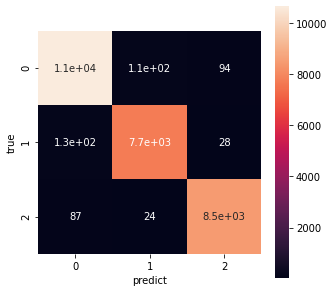

None
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10842
           1       0.98      0.98      0.98      7860
           2       0.99      0.99      0.99      8595

    accuracy                           0.98     27297
   macro avg       0.98      0.98      0.98     27297
weighted avg       0.98      0.98      0.98     27297



In [29]:
#最佳參數
print(grid.best_params_)
#預測結果
#print(grid_predictions)
#混淆矩陣
print(confusion_matrix(y_test, grid_predictions))
#分類結果
print(classification_report(y_test, grid_predictions))

In [32]:
# random forest

#資料劃分
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

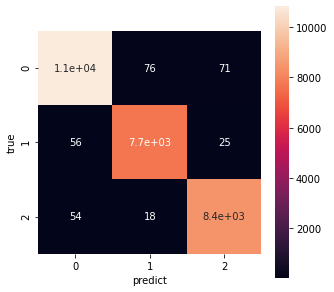

None
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10969
           1       0.99      0.99      0.99      7812
           2       0.99      0.99      0.99      8516

    accuracy                           0.99     27297
   macro avg       0.99      0.99      0.99     27297
weighted avg       0.99      0.99      0.99     27297



In [33]:
model_predictions = model.predict(x_test)
#混淆矩陣
print(confusion_matrix(y_test, model_predictions))
#分類結果
print(classification_report(y_test, model_predictions))

In [24]:
#儲存
file = open('my_model_1P.pickle', 'wb')
pickle.dump(model, file)
file.close()